In this assignment we will practice solving differential equations using tools from scipy (rather than by implementing our own methods). First run the cell below to import the relevant libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import  solve_ivp

It's often helpful to read the manual. Run the cell below and skim the documentation quickly. It's very detailed, but we don't need to understand all of it.

In [2]:
help(solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
    Solve an initial value problem for a system of ODEs.
    
    This function numerically integrates a system of ordinary differential
    equations given an initial value::
    
        dy / dt = f(t, y)
        y(t0) = y0
    
    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.
    
    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must be
    complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
    To solve a problem in the complex domain, pass y0 with a co

Let's start with a very simple example. In the previous assignment we looked at the initial value problem $\frac{dy}{dt} = 2t +1$; $y(0) = 0$ (which has the solution $y(t) = t^2 +t$). Note that I have changed $x$ to $t$ to be consistent with the names used by the solve_ivp function. It's very simple to solve this equation on the interval $(0,5)$ using solve_ivp. Read and then run the code below.

In [3]:
# As with the solver that you wrote in the last assignment, the first step is to define a function that returns the derivative
# Note from the documentation in the help file that this function must have the signature f(t, y), so it needs to take 
# y as an argument even if the derivative doesn't depend on y

fun = lambda t, y: 2*t + 1


sol = solve_ivp(fun, (0, 10), [0])

Let's examine the output of the solver:

In [4]:
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.0000e+00, 1.0000e-04, 1.1000e-03, 1.1100e-02, 1.1110e-01,
       1.1111e+00, 1.0000e+01])
 t_events: None
        y: array([[0.00000000e+00, 1.00010000e-04, 1.10121000e-03, 1.12232100e-02,
        1.23443210e-01, 2.34564321e+00, 1.10000000e+02]])
 y_events: None


As you can see, the solver returns an object with a number of attributes. These are mostly self-explanatory. Let's extract the $y$ values and plot them. We will also plot the exact solution for comparison.

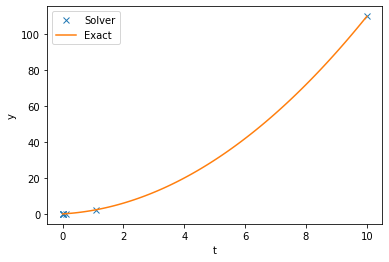

In [5]:
tExact = np.linspace(0, 10, 100)
yExact = tExact**2 + tExact

# note that we need to write sol.y[0, :] rather than sol.y because solve_ivp is made to solve systems, and sol.y is therefor
# (in this case) a two dimensional array. This will become clearer in the later examples.
plt.plot(sol.t, sol.y[0,:] ,'x', tExact, yExact)
plt.xlabel('t')
plt.ylabel('y')
plt.legend(('Solver', 'Exact'))
plt.show()

As you can see, the solver is very accurate, although it only solved for a few values of $t$. This is because the goal of the solver is to get to the end of our timespan with as little computation (hence as few timesteps) as possible. This makes sense, right?

In some cases we might want to access more $t$ values. solve_ivp has appropriate options to support this, as you can see by reading the help file. For example, we can pass the optional argument t_eval to force it to evaluate at certain t values.

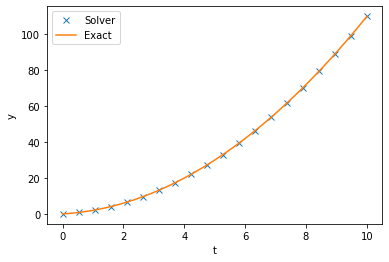

In [6]:
myTs = np.linspace(0, 10, 20) # 20 evenly-spaced points between 0 and 10
sol2 = solve_ivp(fun, (0, 10), [0], t_eval = myTs)
plt.plot(sol2.t, sol2.y[0,:] ,'x', tExact, yExact)
plt.xlabel('t')
plt.ylabel('y')
plt.legend(('Solver', 'Exact'))
plt.show()

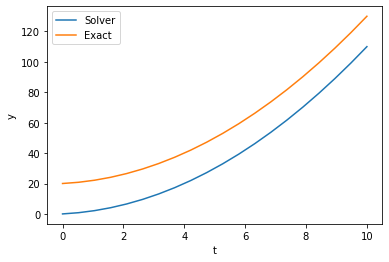

In [7]:
sol3 = solve_ivp(fun, (0, 10), [0, 20], t_eval = myTs)
plt.plot(sol2.t, sol2.y[0,:])
plt.plot(sol3.t, sol3.y[1,:])
plt.xlabel('t')
plt.ylabel('y')
plt.legend(('Solver', 'Exact'))
plt.show()

If we wanted to examine the approximate solution at any value of $t$, the 'dense_output' option can be used. Reading the help file, you can see that the solution will be stored in the "sol" attribute

In [8]:
sol3 = solve_ivp(fun, (0, 10), [0], dense_output=True)
sol3.sol

Here's a quick check:

In [9]:
t = 1.8875656
print("From solver: " + str(sol3.sol(t)))
print("Exact: " + str(t**2 + t))

From solver: [5.45046949]
Exact: 5.45046949430336


solve_ivp has a few more powerful features, such as the "events" argument, which we'll look at later. For now, let's turn to solving a system of equations. The [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) model the populations of two species, one of which is a predator, and one of which is prey (for example foxes and rabbits). The system of equations is: $\begin{align} w'(t) &= \alpha w(t) - \beta w(t) z(t)  \\ z'(t) &= \delta w(t) z(t) - \gamma z(t) \end{align}$, where $w(t)$ is the prey population and $z(t)$ is the predator population. These equations are pretty easy to understand. For example the term $\alpha w(t)$ represents that the prey species grows at a rate $\alpha$ in the absence of the predator. The other numbers $\beta$, $\delta$ and $\gamma$ represent things like how often the predators eat the prey. For more details, follow the link.

Let's try to solve this system using solve_ivp. We will define a vector (array) as $y(t) = \begin{bmatrix} w(t) \\ z(t) \end{bmatrix}$, and hence $y'(t) =  \begin{bmatrix} w'(t) \\ z'(t) \end{bmatrix} = \begin{bmatrix} \alpha w(t) - \beta w(t) z(t)  \\ \delta w(t) z(t) - \gamma z(t) \end{bmatrix}$. solve_ivp will solve the equations for the vector $Y(t)$. Let's see how this works.

The first step is to define a function that returns the derivative of $y(t)$:

In [10]:
# for simpliticity, I am making alpha=beta=delta=gamma=1
def lvFun(t, y):
    xPrey = y[0]
    yPred = y[1]
    yder = [0, 0] # make an array
    
    yder[0] = xPrey - xPrey*yPred
    yder[1] = xPrey*yPred - yPred
    return yder

I hope you realise that `y[0] = w(t)` and `y[1] = z(t)`. I have been very careful and explicit in this code; this would also work: `lvFun = lambda t, y: [y[0] -y[0]*y[1], y[0]*y[1] - y[1]]`. Please look at the definition until it makes sense.

With this definition, it's easy to use solve_ivp. For simplicity, let's see what happens when we start with 100 predators and no prey:

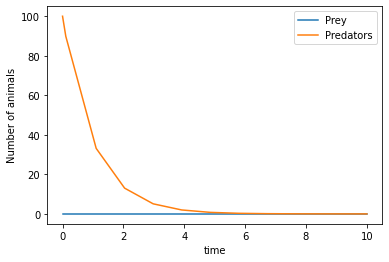

In [11]:
solLV1 = solve_ivp(lvFun, (0, 10), [0, 100])
plt.plot(solLV1.t, solLV1.y[0], solLV1.t, solLV1.y[1])
plt.xlabel('time')
plt.ylabel('Number of animals')
plt.legend(('Prey', 'Predators'))
plt.show()

As you might have expected, the number of prey remains zero, and the number of predators falls to zero (they have nothing to eat, so they all die).

**Your turn:** Investigate what happens when we start with 100 prey and no predators. First look at the equations and write your prediction, and then produce a graph to show how the number of predators and prey varies over time (you might realise that this model is not entirely realistic). 

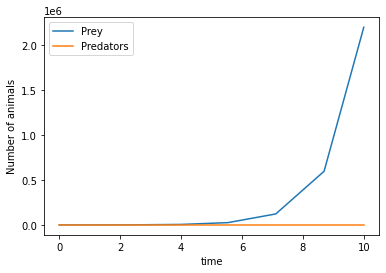

In [12]:
# My predictions: the number of prey should grow exponentially and the number of predators should remain 0
solLV2 = solve_ivp(lvFun, (0, 10), [100, 0])
plt.plot(solLV2.t, solLV2.y[0], solLV2.t, solLV2.y[1])
plt.xlabel('time')
plt.ylabel('Number of animals')
plt.legend(('Prey', 'Predators'))
plt.show()

Let's solve the system again, this time with different values of $\alpha$, $\beta$, etc., and an initial population of 2 predators and 2 prey.

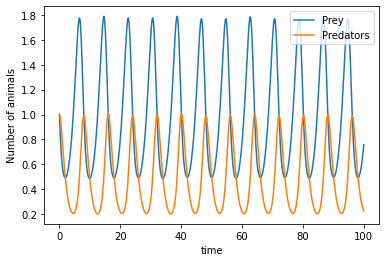

In [29]:
alpha = 2.0/3
beta = 4.0/3
delta = 1
gamma = 1

lvFun2 = lambda t, y: [alpha*y[0] - beta*y[0]*y[1], delta*y[0]*y[1] - gamma*y[1]]

solLV3 = solve_ivp(lvFun2, (0, 100), [1, 1], t_eval = np.linspace(0, 100, 500)) # w0 z0 values were initially both set to 2

plt.plot(solLV3.t, solLV3.y[0], solLV3.t, solLV3.y[1])
plt.xlabel('time')
plt.ylabel('Number of animals')
plt.legend(('Prey', 'Predators'))
plt.show()

As you can see the populations oscillate. The number of prey falls as they are all eaten, and then the lack of prey causes the number of predators to fall. When there are fewer predators, more prey grow, but this later leads to more predators, and the cycle repeats. Note: You might notice a problem with this model in that the number of animals can be fractional, and when the number falls below 1, the population *should* go extinct, but the model doesn't capture this. It's just  avery simple model but is has some interesting features.

**Your turn:** experiment with the initial conditions and see if you can find starting values for the populations that lead to stable populations of predators and prey.

Let's turn to solving a second-order problem. Consider and object which is thrown straight up into the air from ground level with an intial velocity of $v_0$. Writing the height of the object at a time $t$ as $Y(t)$ and neglecting air resistance, we can see that the differential equation governing the object's motion is $Y''(t) = -g$, since it experiences a constant downwards acceleration of $g$, and the initial conditions are $Y'(0) = v_0$ and $Y(0) = 0$. This is a second-order DE, which solve_ivp cannot solve. Instead we must rewrite it as a system of first-order DEs. This sounds confusing, but it's actually very easy. We do it as follows. Define the vector (array) $y(t)$ as $y(t) = \begin{bmatrix} y_1(t) \\ y_2(t) \end{bmatrix}= \begin{bmatrix} Y(t) \\ Y'(t) \end{bmatrix}$. Then we will have $y'(t) = \begin{bmatrix} y_1'(t) \\ y_2'(t) \end{bmatrix} = \begin{bmatrix} Y'(t) \\ Y''(t) \end{bmatrix} = \begin{bmatrix} Y'(t) \\ -g \end{bmatrix} = \begin{bmatrix} y_2(t) \\ -g \end{bmatrix}$

So we have rewritten our second order equation as the system $\begin{align} y_1'(t) &= y_2(t) \\ y_2'(t) &= -g\end{align}$, where $y_1(t) = Y(t)$ and $y_2(t) = Y'(t)$. It seems odd, but it will become clear when you examine the code below. 

Below, I'll solve this equation and plot both the height and velocity as a function of time. Note that we also have an exact solution (this is motion with uniform acceleration): $y'(t) = v_0 - gt$ and $y(t) = v_0 t -\frac{1}{2} g t^2$  (keeping in mind that the initial height is 0.  Since I know from the exact solution that the projectile will land when $t=\frac{2v}/g$, I'll only solve until that time.

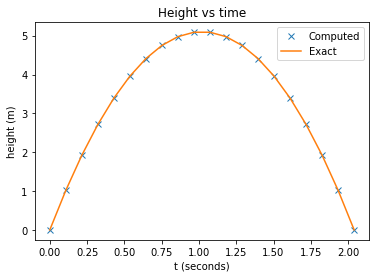

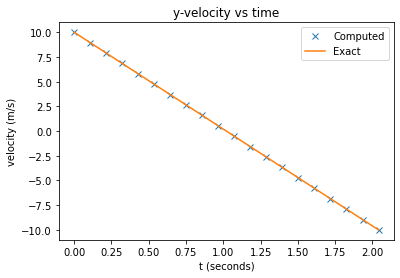

In [12]:
g = 9.8
v0 = 10.0
tEnd = 2*v0 /g
tEval = np.linspace(0, tEnd, 20)
def projFun(t, y):
    yDer = [0, 0]
    yDer[0] = y[1]
    yDer[1] = -g
    return yDer
#Note: "projFun = lambda t, y: [y[1], -g]" would also work fine

solProj = solve_ivp(projFun, (0, tEnd), [0, v0], t_eval=tEval)

yExact = v0*tEval - 0.5*g*tEval**2
vExact = v0 - g*tEval

plt.plot(solProj.t, solProj.y[0], 'x', tEval, yExact)
plt.xlabel('t (seconds)')
plt.ylabel('height (m)')
plt.legend(('Computed', 'Exact'))
plt.title('Height vs time')
plt.show()

plt.plot(solProj.t, solProj.y[1], 'x', tEval, vExact)
plt.xlabel('t (seconds)')
plt.ylabel('velocity (m/s)')
plt.legend(('Computed', 'Exact'))
plt.title('y-velocity vs time')
plt.show()

That was a lot to take in, but hopefully you understood most of it. You should try some tasks. I think completing them all may be challenging, so try those that interest you. I've indicated the level of difficulty for each task.

1. An object undergoing simple harmonic motion has $a(t) = -\omega^2 x(t)$, where $x(t)$ is the displacement, and $a(t)$ is the acceleration, so it obeys the differential equation $x''(t) = -\omega^2 x(t)$.
    1. *(easiest difficulty)* Write code to solve this differential equation and plot the solution. For simplicity, you may use the initial conditions $x(0) = 1$ and $x'(0) = 0$, and set $\omega = 2\pi$. You already know from your classes that the graph of $x$ against $t$ should be sinusoidal with period $T=\frac{2\pi}{\omega}$. Does this agree with your computed solution?
    2. *(medium difficulty)* If there is damping, the differential equation is then $x''(t) =\omega^2 x(t) - \gamma x'(t)$. Pick a value of $\gamma$ and solve this equation and plot its solution alongside that of the undamped equation. Experiment with the value of $\gamma$. If you keep $\omega = 2\pi$, then the system should be underdamped when $\frac{\gamma}{4\pi} < 1$, and overdamped when $\frac{\gamma}{4\pi} > 1$. Is this what you see?
 

2. Copy and modify the code  for the projectile to include an *air resistance* term representing drag. The drag force is given by $F_D = \frac{1}{2} \rho v^2 C_D A$, so the acceleration term due to drag is $\frac{F_D}{m} = \frac{1}{2m} \rho v^2 C_D A$, and the differential equation should therefore be modified to $y''(t) = -g \pm  \frac{1}{2m} \rho (y'(t))^2 C_D A$. The choice of plus or minus depends on whether the object is moving up down - the drag term should always be in the opposite direction to the velocity, so we can write the equation as $y''(t) = -g - \operatorname{sign}{(y'(t))}  \frac{1}{2m} \rho (y'(t))^2 C_D A$, where $\operatorname{sign}{(y'(t))}$ simply gives the sign (+ or -) of $y'(t)$. In python you can use `np.sign()`.  You may take mass of object $m=0.5$kg, density of air $\rho = 1.225$ kg/m^3, drag coefficient $C_D = 0.25$, area $A = 0.019$ m^2, and mass $m=0.4$ kg (these correspond to a soccer ball).
    1. *(medium difficulty)* Plot both the solution without drag, and with drag and see how they differ. Do this for a few different values of initial velocity. Do your results make sense?
    2. *(easiest difficulty)* If the ball is dropped, its velocity will increase, but so will the drag force. Eventually the drag force will be equal to the force of gravity so the velocity will reach a steady value, called the terminal velocity. Solve the equations with appropriate initial conditions to find the terminal velocity. Also write a formula for the terminal velocity and compare your results (if you can't figure out the formula, it's on [wikipedia](https://en.wikipedia.org/wiki/Terminal_velocity)). *Hint: dopped means the initial velocity is zero, and it doesn't really matter what the initial height is. You could start the initial height at some large value, or even start it at zero and realise that it doesn't really matter if it becomes negative.
    
    

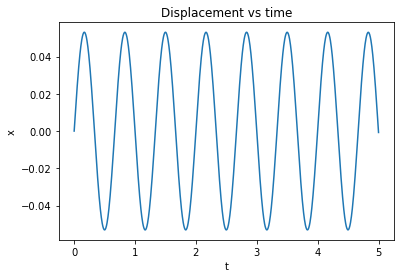

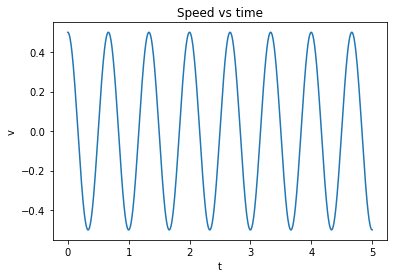

In [21]:
# 1.A Simple harmonic motion without damping

omega = 3*np.pi
v0 = 0.5
tEnd = 5
tEval = np.linspace(0, tEnd, 1000)

def harmFunc(t, y):
    deriv = [0, 0]
    deriv[0] = y[1]
    deriv[1] = - omega**2 * y[0]
    return deriv

harmSol = solve_ivp(harmFunc, (0, tEnd), [0, v0], t_eval=tEval)

plt.plot(harmSol.t, harmSol.y[0])
plt.xlabel('t')
plt.ylabel('x')
plt.title('Displacement vs time')
plt.show()

plt.plot(harmSol.t, harmSol.y[1])
plt.xlabel('t')
plt.ylabel('v')
plt.title('Speed vs time')
plt.show()

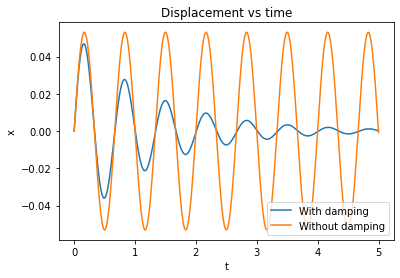

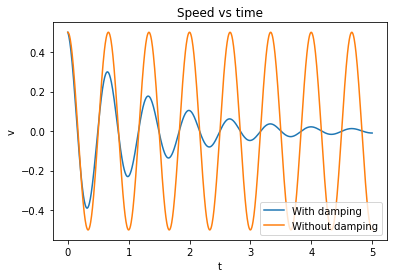

In [22]:
# 1.B Simple harmonic motion with damping

omega = 3*np.pi
gamma = 0.5*np.pi
v0 = 0.5
tEnd = 5
tEval = np.linspace(0, tEnd, 1000)

def harmFunc(t, y):
    deriv = [0, 0]
    deriv[0] = y[1]
    deriv[1] = - omega**2 * y[0] - gamma * y[1]
    return deriv

harmSolDamp = solve_ivp(harmFunc, (0, tEnd), [0, v0], t_eval=tEval)

plt.plot(harmSolDamp.t, harmSolDamp.y[0], harmSol.t, harmSol.y[0])
plt.xlabel('t')
plt.ylabel('x')
plt.legend(('With damping', 'Without damping'))
plt.title('Displacement vs time')
plt.show()

plt.plot(harmSolDamp.t, harmSolDamp.y[1], harmSol.t, harmSol.y[1])
plt.xlabel('t')
plt.ylabel('v')
plt.legend(('With damping', 'Without damping'))
plt.title('Speed vs time')
plt.show()

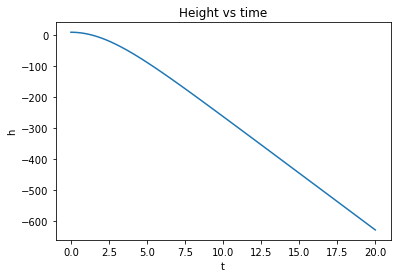

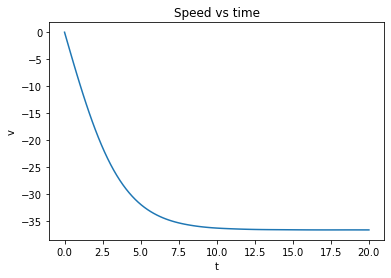

The terminal velocity is -36.7 m/s.


In [23]:
# 2.B Ball is dropped from some height (with air resistance)
g = 9.8
density = 1.225
mass = 0.4
CD = 0.25
area = 0.019
tEnd = 20
tEval = np.linspace(0, tEnd, 100)

def dropBall(t, y):
    derDropBall = [0, 0]
    derDropBall[0] = y[1]
    derDropBall[1] = -g - np.sign(y[1]) * (0.5 / mass) * density * (y[1])**2 * CD * area
    return derDropBall

solDropBall = solve_ivp(dropBall, (0, tEnd), [10, 0], t_eval = tEval )

plt.plot(solDropBall.t, solDropBall.y[0])
plt.xlabel('t')
plt.ylabel('h')
plt.title('Height vs time')
plt.show()

plt.plot(solDropBall.t, solDropBall.y[1])
plt.xlabel('t')
plt.ylabel('v')
plt.title('Speed vs time')
plt.show()

termVel = round( solDropBall.y[1, len(solDropBall.y[1])-1], 2 )
print('The terminal velocity is ' + str(termVel) + ' m/s.' )

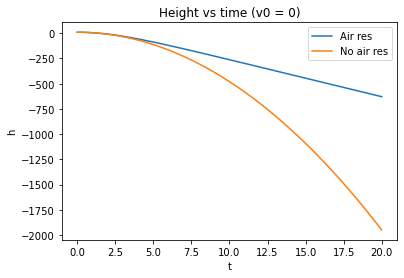

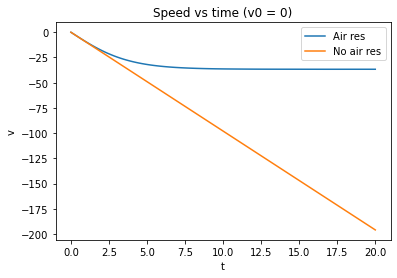

The terminal velocity (v0 = 0) is -36.7 m/s.


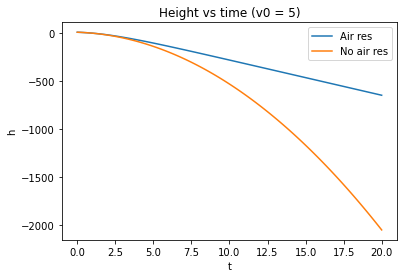

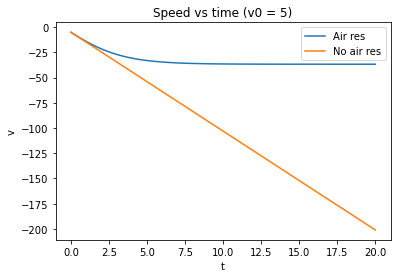

The terminal velocity (v0 = 5) is -36.7 m/s.


In [30]:
# 2.A Comparison of the graphs with air resistance and without
g = 9.8
density = 1.225
mass = 0.4
CD = 0.25
area = 0.019
tEnd = 20
tEval = np.linspace(0, tEnd, 100)

h0 = 10
v0_1 = 0
v0_2 = -5

def dropBallWithout(t, y):
    derDropBall = [0, 0]
    derDropBall[0] = y[1]
    derDropBall[1] = -g
    return derDropBall

def dropBall(t, y):
    derDropBall = [0, 0]
    derDropBall[0] = y[1]
    derDropBall[1] = -g - np.sign(y[1]) * (0.5 / mass) * density * (y[1])**2 * CD * area
    return derDropBall

solDropBallWithout = solve_ivp(dropBallWithout, (0, tEnd), [h0, v0_1], t_eval=tEval)
solDropBall = solve_ivp(dropBall, (0, tEnd), [h0, v0_1], t_eval = tEval)

solDropBallWithout2 = solve_ivp(dropBallWithout, (0, tEnd), [h0, v0_2], t_eval=tEval)
solDropBall2 = solve_ivp(dropBall, (0, tEnd), [h0, v0_2], t_eval = tEval)

plt.plot(solDropBall.t, solDropBall.y[0], solDropBallWithout.t, solDropBallWithout.y[0])
plt.xlabel('t')
plt.ylabel('h')
plt.title('Height vs time (v0 = 0)')
plt.legend(('Air res', 'No air res'))
plt.show()

plt.plot(solDropBall.t, solDropBall.y[1], solDropBallWithout.t, solDropBallWithout.y[1])
plt.xlabel('t')
plt.ylabel('v')
plt.title('Speed vs time (v0 = 0)')
plt.legend(('Air res', 'No air res'))
plt.show()

termVel = round( solDropBall.y[1, len(solDropBall.y[1])-1], 2 )
print('The terminal velocity (v0 = 0) is ' + str(termVel) + ' m/s.' )



plt.plot(solDropBall2.t, solDropBall2.y[0], solDropBallWithout2.t, solDropBallWithout2.y[0])
plt.xlabel('t')
plt.ylabel('h')
plt.title('Height vs time (v0 = 5)')
plt.legend(('Air res', 'No air res'))
plt.show()

plt.plot(solDropBall2.t, solDropBall2.y[1], solDropBallWithout2.t, solDropBallWithout2.y[1])
plt.xlabel('t')
plt.ylabel('v')
plt.title('Speed vs time (v0 = 5)')
plt.legend(('Air res', 'No air res'))
plt.show()

termVel2 = round( solDropBall2.y[1, len(solDropBall2.y[1])-1], 2 )
print('The terminal velocity (v0 = 5) is ' + str(termVel2) + ' m/s.' )